# Backtest Kernel - DEMO

In [1]:
%matplotlib inline

from kernel import *
from oanda import *
from plotting import *

api = OANDAClient(OANDAPracticeConfig())
df = api.get_bars('EUR_USD', 'M30', 5000)
df.tail()

,closeMid,complete,datetime,highMid,lowMid,openMid,time,volume
4995,1.119230,True,2015-09-27 22:00:00,1.119315,1.118375,1.118400,1443405600000000,147
4996,1.119975,True,2015-09-27 22:30:00,1.119975,1.119265,1.119265,1443407400000000,178
4997,1.119390,True,2015-09-27 23:00:00,1.120225,1.119265,1.119950,1443409200000000,176
4998,1.118990,True,2015-09-27 23:30:00,1.119590,1.118830,1.119390,1443411000000000,257
4999,1.118590,False,2015-09-28 00:00:00,1.119085,1.118365,1.119020,1443412800000000,98


##Toy Strategy: DMA with Take_Profit/Stop_Loss

In [2]:
class DMA(StrategyTemplate):
    """
    DMA

    """

    def __init__(self, fast, slow, instrument='EUR_USD'):
        """

        """
        self.instrument = instrument
        self.history = []
        self.slow = slow
        self.fast = fast
        self.has_long = 0
        self.open_price = 0
        self.take_profit = 0

    def on_bar(self, bar):
        """
        Receive one bar, return signal, volume.
        :param bar: dict;
        :return: OrderType(Enum) object.
        """

        self.history.append(bar)
        curr_price = bar[BarColNames.close.value]
        # ---------------------------- #
        slow = np.mean([b[BarColNames.close.value]
                        for b in self.history[-1*self.slow:]])
        fast = np.mean([b[BarColNames.close.value]
                        for b in self.history[-1*self.fast:]])
        if fast > slow and (not self.has_long):
            self.has_long = 1
            self.open_price = curr_price
            return OrderType.buy, 10000
        if fast > slow and curr_price - self.open_price >= 0.01:  # take profit
            self.has_long = 1
            self.open_price = 0
            return OrderType.sell, 10000
        if curr_price - self.open_price <= -0.005:  # stop loss
            self.has_long = 1
            self.open_price = 0
            return OrderType.sell, 10000
        elif fast < slow:
            self.has_long = 0
            return OrderType.sell, 10000

        # ---------------------------- #
        return OrderType.none, 0


##Report

* plotting.report()

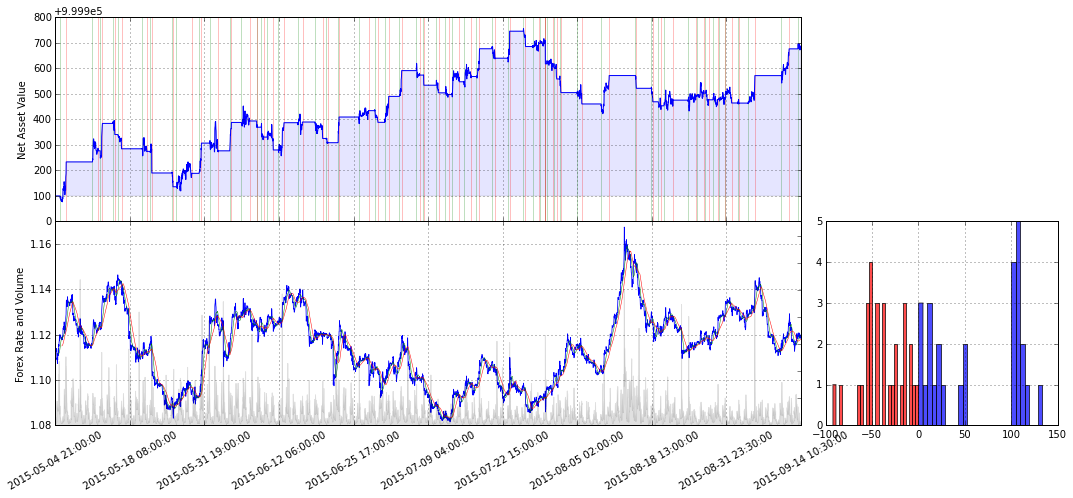

In [3]:
# Toy strategy


k = Kernel.naive(df)
s = DMA(20,45)
k.run_naive(s)
ax1,ax2,ax3 = report(k,ma1=20,ma2=45)


##Export executed orders
* Kernel.export_executed_orders()

In [4]:
k.export_executed_orders().head(10)

,direction,instrument,price,target,time,volume
0,OrderType.buy,EUR_USD,1.120105,None,2015-05-05 12:30:00,10000
1,OrderType.sell,EUR_USD,1.133455,None,2015-05-06 09:30:00,10000
2,OrderType.buy,EUR_USD,1.117625,None,2015-05-12 01:30:00,10000
3,OrderType.sell,EUR_USD,1.121995,None,2015-05-12 21:30:00,10000
4,OrderType.buy,EUR_USD,1.125085,None,2015-05-13 03:30:00,10000
5,OrderType.sell,EUR_USD,1.135805,None,2015-05-13 11:00:00,10000
6,OrderType.buy,EUR_USD,1.140335,None,2015-05-14 21:00:00,10000
7,OrderType.sell,EUR_USD,1.135990,None,2015-05-15 04:30:00,10000
8,OrderType.buy,EUR_USD,1.145140,None,2015-05-15 15:00:00,10000
9,OrderType.sell,EUR_USD,1.139545,None,2015-05-18 03:00:00,10000


##Export positions
* Kernel.export_positions()

In [5]:
k.export_positions().head(10)

,close_price,close_time,direction,instrument,open_price,open_time,realized_pnl,volume
0,1.133455,2015-05-06 09:30:00,PositionType.long,EUR_USD,1.120105,2015-05-05 12:30:00,133.50,10000
1,1.121995,2015-05-12 21:30:00,PositionType.long,EUR_USD,1.117625,2015-05-12 01:30:00,43.70,10000
2,1.135805,2015-05-13 11:00:00,PositionType.long,EUR_USD,1.125085,2015-05-13 03:30:00,107.20,10000
3,1.135990,2015-05-15 04:30:00,PositionType.long,EUR_USD,1.140335,2015-05-14 21:00:00,-43.45,10000
4,1.139545,2015-05-18 03:00:00,PositionType.long,EUR_USD,1.145140,2015-05-15 15:00:00,-55.95,10000
5,1.111220,2015-05-21 16:30:00,PositionType.long,EUR_USD,1.112235,2015-05-20 23:00:00,-10.15,10000
6,1.107970,2015-05-22 08:30:00,PositionType.long,EUR_USD,1.116445,2015-05-22 03:00:00,-84.75,10000
7,1.086200,2015-05-27 07:30:00,PositionType.long,EUR_USD,1.091595,2015-05-27 04:00:00,-53.95,10000
8,1.095255,2015-05-31 23:00:00,PositionType.long,EUR_USD,1.090005,2015-05-27 19:00:00,52.50,10000
9,1.104440,2015-06-02 07:00:00,PositionType.long,EUR_USD,1.092585,2015-06-01 23:00:00,118.55,10000


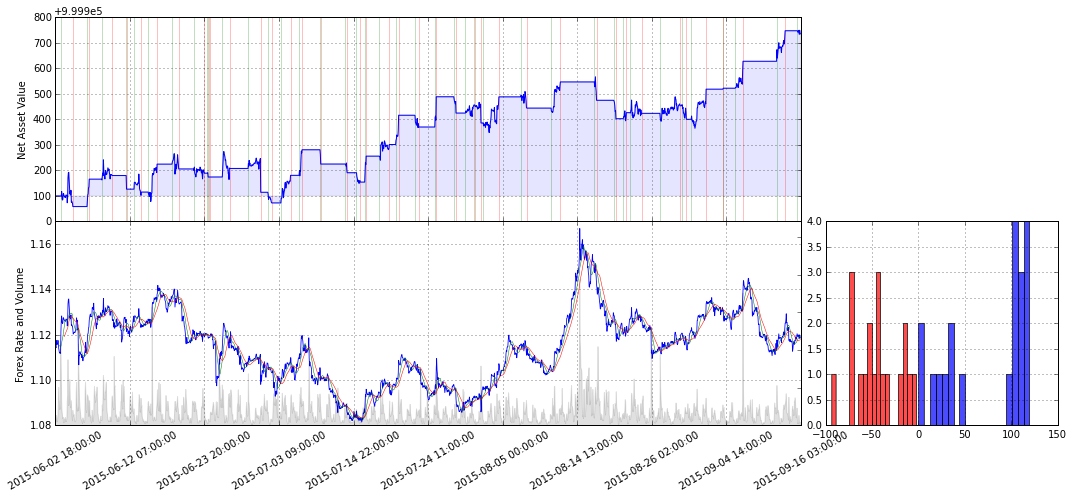

In [6]:
s2 = DMA(12,25)
k = Kernel.naive(api.get_bars('EUR_USD', 'H1', 2000))
k.run_naive(s2)
ax1,ax2,ax3 = report(k,ma1=12,ma2=25)

In [8]:
class DMA_200(StrategyTemplate):
    """
    DMA_200

    """

    def __init__(self, fast, slow=200, instrument='EUR_USD'):
        """

        """
        self.instrument = instrument
        self.history = []
        self.slow = slow
        self.fast = fast
        self.has_long = 0
        self.open_price = 0
        self.take_profit = 0

    def on_bar(self, bar):
        """
        Receive one bar, return signal, volume.
        :param bar: dict;
        :return: OrderType(Enum) object.
        """

        self.history.append(bar)
        curr_price = bar[BarColNames.close.value]
        # ---------------------------- #
        slow = np.mean([b[BarColNames.close.value]
                        for b in self.history[-1*self.slow:]])
        fast = np.mean([b[BarColNames.close.value]
                        for b in self.history[-1*self.fast:]])
        if fast > slow and (not self.has_long):
            self.has_long = 1
            self.open_price = curr_price
            return OrderType.buy, 10000
        elif fast < slow:
            self.has_long = 0
            return OrderType.sell, 10000

        # ---------------------------- #
        return OrderType.none, 0


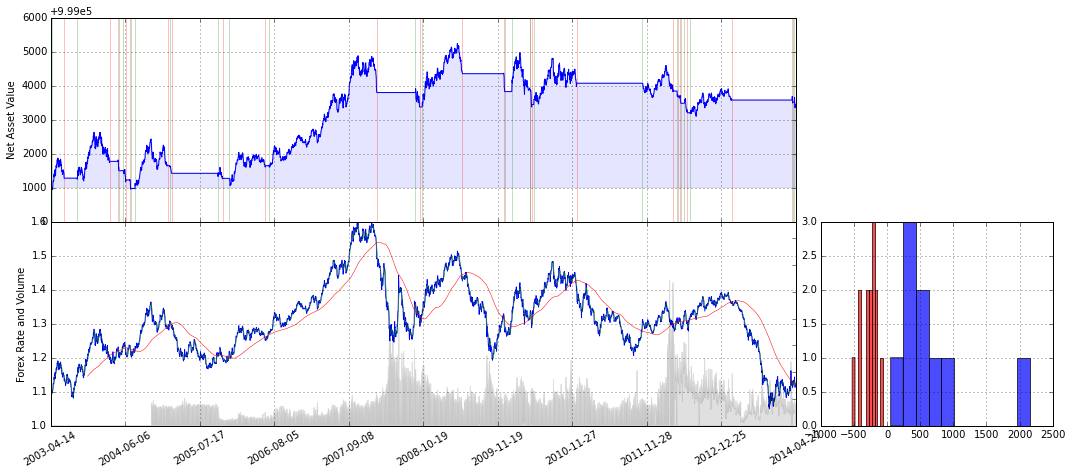

In [9]:
s3 = DMA_200(10)
k = Kernel.naive(api.get_bars('EUR_USD', 'D', 4000))
k.run_naive(s3)
ax1,ax2,ax3 = report(k,ma1=7,ma2=200)